In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

GPU Type: NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.


ARCH Value: GPU must be added to GPU Commands


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import numpy as np
from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Reshape, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
import cv2
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Dataset_split.zip" -d "/content/drive/MyDrive/Colab Notebooks/Dataset_split"

Archive:  /content/drive/MyDrive/Colab Notebooks/Dataset_split.zip
   creating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/
   creating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/
  inflating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/Pa Lulun Pao (101).jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/Pa Lulun Pao (11).jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/Pa Lulun Pao (110).jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/Pa Lulun Pao (112).jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/Pa Lulun Pao (113).jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/Pa Lulun Pao (119).jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/Dataset_split/test/Pa Lulun Pao/Pa Lulun Pao (12).jpg  
  inflating: /c

In [ ]:
print("Dataset Train :")
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/Dataset_split/train'))
print("Dataset Validasi")
print(os.listdir('/content/drive/MyDrive/Colab Notebooks/Dataset_split/test'))

Dataset Train :
['Pa Somba', 'Pa Tangke Lumu', 'Pa Lulun Pao', 'Pa Tumuru']
Dataset Validasi
['Pa Lulun Pao', 'Pa Tumuru', 'Pa Somba', 'Pa Tangke Lumu']


In [ ]:
train_directory = "/content/drive/MyDrive/Colab Notebooks/Dataset_split/train"
valid_directory = "/content/drive/MyDrive/Colab Notebooks/Dataset_split/test"

#1

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 100
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  0.0001


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
resnet_model = getResNet50Model(lastFourTrainable=True)

102967424/102967424 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/100
50/50 [==============================] - 29s 315ms/step - loss: 1.0625 - accuracy: 0.5419 - val_loss: 1.4055 - val_accuracy: 0.2552
Epoch 2/100
50/50 [==============================] - 14s 272ms/step - loss: 0.6876 - accuracy: 0.7613 - val_loss: 1.2223 - val_accuracy: 0.3281
Epoch 3/100
50/50 [==============================] - 14s 276ms/step - loss: 0.5302 - accuracy: 0.8288 - val_loss: 1.1558 - val_accuracy: 0.3776
Epoch 4/100
50/50 [==============================] - 14s 278ms/step - loss: 0.4358 - accuracy: 0.8469 - val_loss: 1.0980 - val_accuracy: 0.3646
Epoch 5/100
50/50 [==============================] - 14s 282ms/step - loss: 0.3474 - accuracy: 0.8906 - val_loss: 0.9036 - val_accuracy: 0.5417
Epoch 6/100
50/50 [==============================] - 14s 273ms/step - loss: 0.3220 - accuracy: 0.8844 - val_loss: 0.8508 - val_accuracy: 0.6042
Epoch 7/100
50/50 [==============================] - 14s 273ms/step - loss: 0.2683 - accuracy: 0.9187 - val_loss: 0.7032 - val_accuracy:

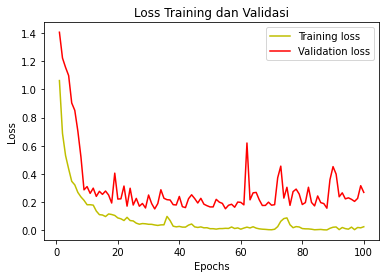

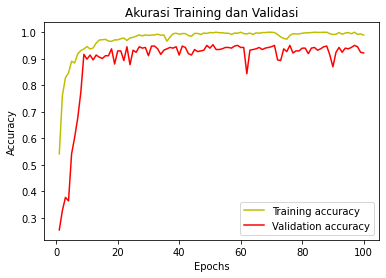

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model100.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights100.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model100.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model100.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 37ms/step
Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         6

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Report Testing :
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



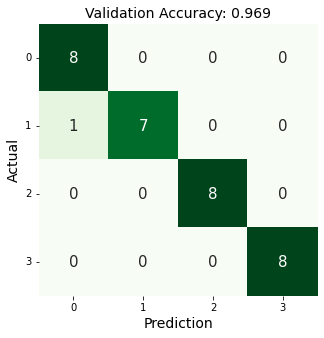

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#2

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 200
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  5e-07


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/200
50/50 [==============================] - 17s 282ms/step - loss: 1.4219 - accuracy: 0.2644 - val_loss: 1.4475 - val_accuracy: 0.2214
Epoch 2/200
50/50 [==============================] - 13s 260ms/step - loss: 1.3876 - accuracy: 0.3206 - val_loss: 1.4379 - val_accuracy: 0.2135
Epoch 3/200
50/50 [==============================] - 13s 260ms/step - loss: 1.3591 - accuracy: 0.3762 - val_loss: 1.4132 - val_accuracy: 0.2578
Epoch 4/200
50/50 [==============================] - 13s 266ms/step - loss: 1.3338 - accuracy: 0.4137 - val_loss: 1.3931 - val_accuracy: 0.2552
Epoch 5/200
50/50 [==============================] - 13s 263ms/step - loss: 1.3149 - accuracy: 0.4319 - val_loss: 1.3661 - val_accuracy: 0.3411
Epoch 6/200
50/50 [==============================] - 13s 261ms/step - loss: 1.3000 - accuracy: 0.4444 - val_loss: 1.3360 - val_accuracy: 0.4167
Epoch 7/200
50/50 [==============================] - 13s 263ms/step - loss: 1.2855 - accuracy: 0.4588 - val_loss: 1.3121 - val_accuracy:

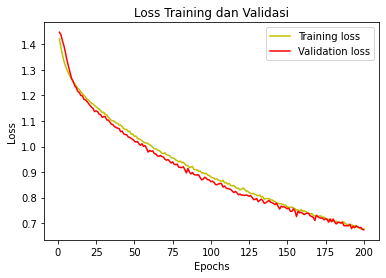

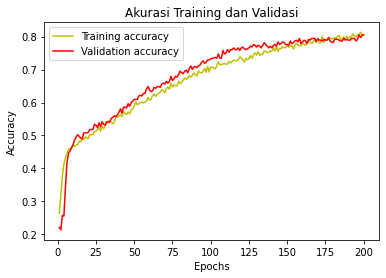

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model200.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights200.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model200.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model200.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 34ms/step
Report Training :
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.88      0.88      0.88         8
           2       0.91      0.91      0.91        11
           3       1.00      0.88      0.93         8

    accuracy                           0.91        32
   macro avg       0.90      0.91      0.91        32
weighted avg       0.91      0.91      0.91        32

Report Testing :
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.60      0.75      0.67         8
           2       0.50      0.60      0.55         5
           3       1.00      0.88      0.93         8

    accuracy                           0.78        32
   macro avg       0.78      0.76      0.76        32
weighted avg       0.82      0.78      0.79        32



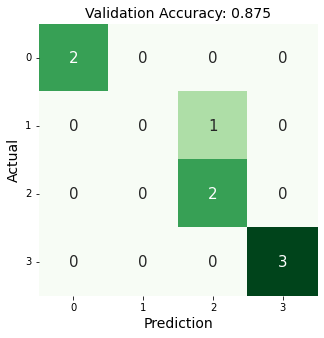

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#3

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 300
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  5e-07


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/300
50/50 [==============================] - 18s 299ms/step - loss: 1.6746 - accuracy: 0.2500 - val_loss: 1.6567 - val_accuracy: 0.2448
Epoch 2/300
50/50 [==============================] - 15s 293ms/step - loss: 1.5975 - accuracy: 0.2519 - val_loss: 1.5934 - val_accuracy: 0.2552
Epoch 3/300
50/50 [==============================] - 14s 274ms/step - loss: 1.5365 - accuracy: 0.2506 - val_loss: 1.5593 - val_accuracy: 0.2422
Epoch 4/300
50/50 [==============================] - 14s 275ms/step - loss: 1.4840 - accuracy: 0.2544 - val_loss: 1.5198 - val_accuracy: 0.2474
Epoch 5/300
50/50 [==============================] - 14s 280ms/step - loss: 1.4404 - accuracy: 0.2606 - val_loss: 1.4814 - val_accuracy: 0.2526
Epoch 6/300
50/50 [==============================] - 13s 259ms/step - loss: 1.4050 - accuracy: 0.2637 - val_loss: 1.4328 - val_accuracy: 0.2682
Epoch 7/300
50/50 [==============================] - 14s 283ms/step - loss: 1.3738 - accuracy: 0.2756 - val_loss: 1.3935 - val_accuracy:

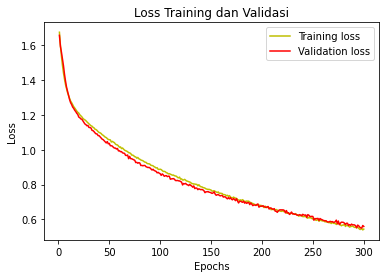

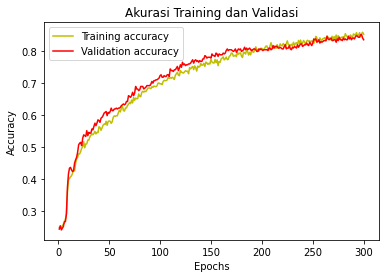

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model300.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights300.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model300.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model300.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 35ms/step
Report Training :
              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.80      0.80      0.80         5
           2       0.83      0.91      0.87        11
           3       0.83      0.83      0.83         6

    accuracy                           0.81        32
   macro avg       0.81      0.81      0.81        32
weighted avg       0.81      0.81      0.81        32

Report Testing :
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.89      0.89      0.89         9
           2       0.89      0.89      0.89         9
           3       0.83      0.83      0.83         6

    accuracy                           0.84        32
   macro avg       0.84      0.84      0.84        32
weighted avg       0.84      0.84      0.84        32



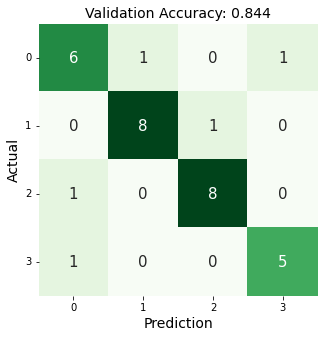

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#4

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 400
batch_size = 32
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  5e-07


In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

# Load data validasi
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/400
50/50 [==============================] - 17s 281ms/step - loss: 1.3912 - accuracy: 0.3106 - val_loss: 1.4363 - val_accuracy: 0.3203
Epoch 2/400
50/50 [==============================] - 13s 260ms/step - loss: 1.3631 - accuracy: 0.3406 - val_loss: 1.4301 - val_accuracy: 0.3099
Epoch 3/400
50/50 [==============================] - 13s 262ms/step - loss: 1.3401 - accuracy: 0.3494 - val_loss: 1.4083 - val_accuracy: 0.2969
Epoch 4/400
50/50 [==============================] - 13s 265ms/step - loss: 1.3216 - accuracy: 0.3681 - val_loss: 1.3833 - val_accuracy: 0.2891
Epoch 5/400
50/50 [==============================] - 13s 261ms/step - loss: 1.3036 - accuracy: 0.3938 - val_loss: 1.3614 - val_accuracy: 0.2786
Epoch 6/400
50/50 [==============================] - 13s 261ms/step - loss: 1.2898 - accuracy: 0.4387 - val_loss: 1.3298 - val_accuracy: 0.3151
Epoch 7/400
50/50 [==============================] - 13s 258ms/step - loss: 1.2756 - accuracy: 0.4525 - val_loss: 1.3014 - val_accuracy:

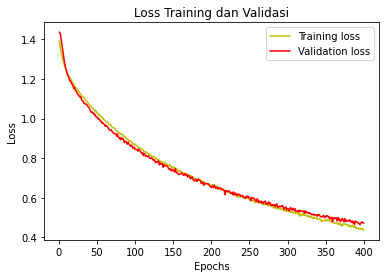

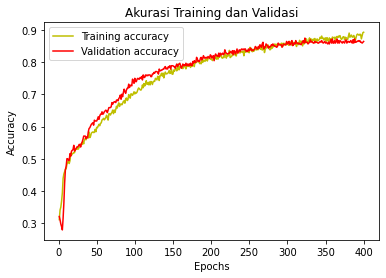

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model400.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights400.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model400.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model400.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

1/1 [==============================] - 0s 34ms/step
Report Training :
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00        10
           2       0.92      1.00      0.96        12
           3       0.83      0.83      0.83         6

    accuracy                           0.94        32
   macro avg       0.94      0.90      0.91        32
weighted avg       0.94      0.94      0.94        32

Report Testing :
              precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.89      0.73      0.80        11
           2       0.80      0.89      0.84         9
           3       0.57      0.80      0.67         5

    accuracy                           0.81        32
   macro avg       0.82      0.82      0.81        32
weighted avg       0.84      0.81      0.82        32



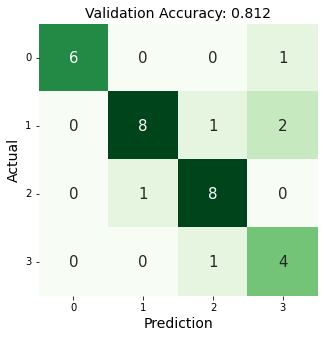

In [ ]:
plt.figure(figsize=(11, 5))
plt.subplot(121)
labels = np.unique(y_pred_train_argmax)
# cm = confusion_matrix(y_train_argmax, y_pred_train_argmax, labels=labels)
# sns.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
# plt.title(f"Training Accuracy: {accuracy_score(y_train_argmax, y_pred_train_argmax):.3f}", fontsize=14)
# plt.xlabel('Prediction', fontsize=14)
# plt.ylabel('Actual', fontsize=14)
# plt.yticks(rotation=0, verticalalignment='center')
# plt.subplot(122)
cm = confusion_matrix(y_test_argmax, y_pred_test_argmax, labels=labels)
sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot_kws={"fontsize":15})
plt.title(f"Validation Accuracy: {accuracy_score(y_test_argmax, y_pred_test_argmax):.3f}", fontsize=14)
plt.xlabel('Prediction', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.yticks(rotation=0, verticalalignment='center')

plt.show()

#5

In [ ]:
img_rows = 224
img_cols = 224
input_shape = (img_rows,img_cols,3)
epochs = 500
batch_size = 8
num_of_classes = 4
num_of_train_samples = 1600
num_of_valid_samples = 400

lr = 1e-3
if epochs > 180:
    lr *= 0.5e-3
elif epochs > 160:
    lr *= 1e-3
elif epochs > 120:
    lr *= 1e-2
elif epochs > 80:
    lr *= 1e-1
print('Learning rate: ', lr)

Learning rate:  5e-07


Normalisasi

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=train_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(directory=valid_directory, 
                                                                         class_mode='categorical', 
                                                                         batch_size=batch_size,
                                                                         target_size=(img_rows, img_cols),
                                                                         color_mode="rgb",
                                                                         shuffle=True)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
import tensorflow as tf
def getResNet50Model(lastFourTrainable=False):
  resnet_model = ResNet50(weights='imagenet', input_shape=input_shape, include_top=True)
  
  # Make all layers non-trainable
  for layer in resnet_model.layers[:]:
    layer.trainable = False
  
  # Add fully connected layer which have 1024 neuron to ResNet-50 model
  output = resnet_model.get_layer('avg_pool').output
  output = Flatten(name='new_flatten')(output)
  output = Dense(units=1024, activation='relu', name='new_fc')(output)
  output = Dense(units=4, activation='softmax')(output)
  resnet_model = Model(resnet_model.input, output)

  # Make last 4 layers trainable if lastFourTrainable == True
  if lastFourTrainable == True:
    resnet_model.get_layer('conv5_block3_2_bn').trainable = True
    resnet_model.get_layer('conv5_block3_3_conv').trainable = True
    resnet_model.get_layer('conv5_block3_3_bn').trainable = True
    resnet_model.get_layer('new_fc').trainable = True
  
  # Compile ResNet-50 model
  resnet_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
  resnet_model.summary()


  return resnet_model

In [ ]:
# Get ResNet-50 Model with lastFourTrainable=False
resnet_model = getResNet50Model(lastFourTrainable=True)

102981632/102967424 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
%%time
history = resnet_model.fit_generator(train_generator,
                                     epochs=epochs,
                                     steps_per_epoch=num_of_train_samples// batch_size,
                                     validation_data=valid_generator,
                                     validation_steps=num_of_valid_samples // batch_size)

Epoch 1/500
200/200 [==============================] - 1396s 7s/step - loss: 1.5151 - accuracy: 0.2037 - val_loss: 1.4943 - val_accuracy: 0.2475
Epoch 2/500
200/200 [==============================] - 15s 77ms/step - loss: 1.3918 - accuracy: 0.2950 - val_loss: 1.3644 - val_accuracy: 0.3525
Epoch 3/500
200/200 [==============================] - 15s 77ms/step - loss: 1.3268 - accuracy: 0.4131 - val_loss: 1.2954 - val_accuracy: 0.4475
Epoch 4/500
200/200 [==============================] - 15s 77ms/step - loss: 1.2923 - accuracy: 0.4431 - val_loss: 1.2634 - val_accuracy: 0.4775
Epoch 5/500
200/200 [==============================] - 16s 77ms/step - loss: 1.2748 - accuracy: 0.4406 - val_loss: 1.2411 - val_accuracy: 0.4800
Epoch 6/500
200/200 [==============================] - 16s 82ms/step - loss: 1.2549 - accuracy: 0.4613 - val_loss: 1.2225 - val_accuracy: 0.4900
Epoch 7/500
200/200 [==============================] - 15s 77ms/step - loss: 1.2352 - accuracy: 0.4650 - val_loss: 1.2056 - val_ac

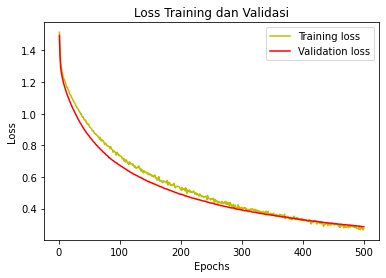

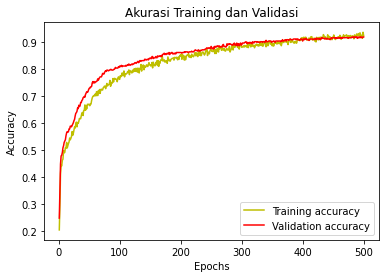

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Akurasi Training dan Validasi')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
classifier_json=resnet_model.to_json()
with open("/content/drive/MyDrive/Colab Notebooks/Models/model500.json", "w") as json_file:
    json_file.write(classifier_json)
# serialize weights to HDF5
    resnet_model.save_weights("/content/drive/MyDrive/Colab Notebooks/Models/my_model_weights500.h5")
    resnet_model.save("/content/drive/MyDrive/Colab Notebooks/Models/model500.h5")
    print("Saved model to disk")

Saved model to disk


In [ ]:
labels = (train_generator.class_indices)
print(labels)

{'Pa Lulun Pao': 0, 'Pa Somba': 1, 'Pa Tangke Lumu': 2, 'Pa Tumuru': 3}


In [ ]:
#Load model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Models/model500.h5', compile=False)

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(valid_generator)
# Evaluation matrix
y_pred_train = resnet_model.predict(X_train)
y_pred_train_argmax = np.argmax(y_pred_train, axis=1)
y_train_argmax = np.argmax(y_train, axis=1)
y_pred_test = resnet_model.predict(X_test)
y_pred_test_argmax = np.argmax(y_pred_test, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

print("Report Training :")
print(classification_report(y_train_argmax, y_pred_train_argmax))
print("Report Testing :")
print(classification_report(y_test_argmax, y_pred_test_argmax))

Report Training :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

Report Testing :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8

